In [57]:
# Activate/Deactivate automatic debugger on exceptions
%pdb off

Automatic pdb calling has been turned OFF


# Importing the Libraries

In [2]:
%run nanonis_library
%run main_functions.ipynb
%run median_filtering.ipynb

# Extracting spectroscopic Data

In [3]:
data_PATH = "C:/Users/eugen/Documents/CODE/STM/Grids/Data"
file_name = "grid-spectroscopy004.3ds"
file_PATH = data_PATH + '/' + file_name

extract_grid = Grid(file_PATH)
data = extract_grid._load_data()      # opens both the topography and the spectroscopic images

topo = data['params']                 # parameters taken at the grid points 
current_cube = data['Current (A)']    # current data

# bias_cube = data['Bias (V)']          # bias data 3D
# bias_line = bias_cube[0][0]           # the bias points swept during each spectrum
bias_line = np.linspace(1.8, -0.2, 1000)
spectrum_length = len(bias_line)

x_points = len(current_cube[0,:,0])
y_points = len(current_cube[:,0,0])

bias_start = (bias_line[0] * 1000)                # spectrum starting point (meV)
bias_end = (bias_line[-1] * 1000)                 # spectrum ending point (meV)

len_x = (-topo[0][0][2] + topo[0][-1][2]) * 10**9               # map size along X (nm)
len_y = abs((-topo[0][0][3] + topo[-1][0][3])* 10**9)           # map size along Y (nm)

print("Number of points in spectroscopy:", spectrum_length,
      "\nBias_Start:", bias_start, 'mV', "\nBias_End:", bias_end, 'mV' 
      "\nNumber of points in x:",x_points, "\nNumber of points in y:", y_points,
      "\nLenght in x:", len_x, 'nm', "\nLenght in y:", len_y, 'nm')

# Read params
params = {'len_x':len_x, 'len_y': len_y, 'x_points':x_points , 'y_points': y_points, 'bias_start':bias_start,
          'bias_end':bias_end, 'spectrum_length': spectrum_length}

Number of points in spectroscopy: 1000 
Bias_Start: 1800.0 mV 
Bias_End: -200.0 mV
Number of points in x: 320 
Number of points in y: 320 
Lenght in x: 251.11705781455385 nm 
Lenght in y: 250.78753651541774 nm


# Import widgets

In [4]:
%run widgets.ipynb

# Median filtering (scipy)

In [57]:
# Define a function to update the filtered dataset and display the image
def median_filter_plot(selected_bias_value, window_size, threshold, vmin, vmax):
    
    # Clear the previous plot
    IPython.display.clear_output(wait=True)
    
    # Find the index of the closest value in the array
    closest_value_index = np.abs(bias_line - selected_bias_value).argmin()
    # Select the slice along the bias axis based on the index
    selected_slice = current_cube[:,:,closest_value_index]

    # Apply median filter to the selected slice using SciPy's medfilt2d function and the threshold
    filtered_slice = scipy.signal.medfilt2d(selected_slice, window_size)
    threshold *= std(selected_slice)
    filtered_slice += threshold * tanh((selected_slice - filtered_slice) / threshold)

    # Subtracts the median of each line to that line (flattens the changes of the tip)
    filtered_slice = list(map(lambda line: line - np.median(line), filtered_slice)) 
    
    # Plot the images
    fig, axs = plt.subplots(1, 2, figsize=(15, 8))  # Adjust the figure size here
    plt.suptitle("Median-filtered")
    
    # Plot the filtered slice (median-thesholded filter)
    im1 = axs[0].imshow(filtered_slice, cmap='viridis')
    axs[0].set_title(f'I(V) @ {selected_bias_value:.4f} V')
    axs[0].axis('off')
    
    # Plot the FT to get vmin and vmax
    
    im2 = axs[1].imshow(log(abs(np.fft.fftshift(np.fft.fft2(filtered_slice)))), cmap='viridis')
    
    # Get current color limits for the FT (vmin and vmax)
    auto_vmin, auto_vmax = axs[1].images[0].get_clim()

    # Update the range sliders with auto_vmin and auto_vmax
    vmin_slider.min = auto_vmin
    vmin_slider.max = auto_vmax
    vmin_slider.step = (auto_vmax - auto_vmin) / 100  # Adjust the step size based on the range
    vmax_slider.min = auto_vmin
    vmax_slider.max = auto_vmax
    vmax_slider.step = (auto_vmax - auto_vmin) / 100  # Adjust the step size based on the range

    # Plot the FT for good
    axs[1].clear()
    im2 = axs[1].imshow(log(abs(np.fft.fftshift(np.fft.fft2(filtered_slice)))), cmap='viridis', vmin=vmin, vmax=vmax)
    axs[1].set_title("FT")
    axs[1].axis('off')
    
    plt.show()

    
# Create a slider widgets
bias_slider = widgets.SelectionSlider(options=[("%g"%i, i) for i in bias_line], description='Bias')
window_size_slider = widgets.IntSlider(value=3, min=1, max=9, step=2, description='Window Size')
threshold_slider = widgets.FloatSlider(value=1, min=0.1, max=2, step =0.1, description='Threshold')
vmin_slider = widgets.FloatSlider(value=-1000, min=-1000, max=0, step=1E-11, description='FT vmin')
vmax_slider = widgets.FloatSlider(value=1000, min=0, max=1000, step=1E-11, description='FT vmax')

# Define interactive output with a button to manually trigger the update
interact_manual(median_filter_plot, selected_bias_value=bias_slider, window_size=window_size_slider, threshold=threshold_slider, vmin=vmin_slider, vmax=vmax_slider)

interactive(children=(SelectionSlider(description='Bias', options=(('1.8', 1.8), ('1.798', 1.797997997997998),…

<function __main__.median_filter_plot(selected_bias_value, window_size, threshold, vmin, vmax)>

# Filter the whole dataset

In [6]:
# Define a function to apply the filter to the whole dataset and save it
def apply_filter_and_save(window_size, threshold, selected_bias_value):
    filtered_data = np.empty_like(current_cube)

    for i in range(current_cube.shape[2]):
        # Apply median filter to the slice along the third dimension using the specified parameters
        filtered_slice = scipy.signal.medfilt2d(current_cube[:,:,i], kernel_size=window_size)
        threshold_data = threshold * std(current_cube[:,:,i])
        filtered_data[:,:,i] = filtered_slice + threshold_data * tanh((current_cube[:,:,i] - filtered_slice) / threshold)
        # Subtracts the median of each line to that line (flattens the changes of the tip)
        filtered_data[:,:,i] = list(map(lambda line: line - np.median(line), filtered_data[:,:,i])) 

    
    # Save the filtered data
    np.save('{}_median-filtered.npy'.format(file_PATH[:-4]), filtered_data)


    # Find the index of the closest value in the array
    closest_value_index = np.abs(bias_line - selected_bias_value).argmin()
    plt.imshow(filtered_data[:,:,closest_value_index], cmap='viridis')

# Create a slider widget for selecting the window size, threshold and bias values
window_size_slider = widgets.IntSlider(value=3, min=1, max=9, step=1, description='Window Size')
threshold_slider = widgets.FloatSlider(value=1, min=0.1, max=2, step=0.1, description='Threshold')
bias_slider = widgets.SelectionSlider(options=[("%g"%i, i) for i in bias_line], description='Bias')

# Define interactive output with a button to manually trigger the update
interact_manual(apply_filter_and_save, window_size=window_size_slider, threshold=threshold_slider, selected_bias_value=bias_slider)

interactive(children=(IntSlider(value=3, description='Window Size', max=9, min=1), FloatSlider(value=1.0, desc…

<function __main__.apply_filter_and_save(window_size, threshold, selected_bias_value)>

# Derivate

In [14]:
current_cube = np.load('{}_median-filtered.npy'.format(file_PATH[:-4]))

# Derivating the data
derivated_current_cube_0 = np.apply_along_axis(np.diff, 0, current_cube) / abs(bias_line[1] - bias_line[0])

derivated_current_cube_1 = np.apply_along_axis(np.diff, 1, current_cube) / abs(bias_line[1] - bias_line[0])

derivated_current_cube_2 = np.apply_along_axis(np.diff, 2, current_cube) / abs(bias_line[1] - bias_line[0])

print(derivated_current_cube_0.shape)
print(derivated_current_cube_1.shape)
print(derivated_current_cube_2.shape)

(319, 320, 1000)
(320, 319, 1000)
(320, 320, 999)


In [15]:
def derive_and_plot_0(selected_bias_value, vmin, vmax):
    # Clear the previous plot
    IPython.display.clear_output(wait=True)

    # Find the index of the closest value in the array and select the slice at a certain bias
    closest_value_index = np.abs(bias_line - selected_bias_value).argmin()
    selected_slice = derivated_current_cube_0[:,:,closest_value_index]

    # Plot the derived slice
    fig, axs = plt.subplots(1, 2, figsize=(15, 8))  # Adjust the figure size here
    plt.suptitle("Derivated")
    
    im1 = axs[0].imshow(selected_slice, cmap='viridis')
    axs[0].set_title(f'dI/dV @ {selected_bias_value:.3f} V')
    axs[0].axis('off')
    
    # Plot the FT to get vmin and vmax
    im2 = axs[1].imshow(log(abs(np.fft.fftshift(np.fft.fft2(selected_slice)))), cmap='viridis')
    auto_vmin, auto_vmax = axs[1].images[0].get_clim()

    # Update the range sliders with auto_vmin and auto_vmax
    vmin_slider.min = auto_vmin
    vmin_slider.max = auto_vmax
    vmin_slider.step = (auto_vmax - auto_vmin) / 100  # Adjust the step size based on the range
    vmax_slider.min = auto_vmin
    vmax_slider.max = auto_vmax
    vmax_slider.step = (auto_vmax - auto_vmin) / 100  # Adjust the step size based on the range

    # Plot the FT for good
    axs[1].clear()
    im2 = axs[1].imshow(log(abs(np.fft.fftshift(np.fft.fft2(selected_slice)))), cmap='viridis', vmin=vmin, vmax=vmax)
    axs[1].set_title("FT")
    axs[1].axis('off')
    
    plt.show()

def derive_and_plot_1(selected_bias_value, vmin, vmax):
    # Clear the previous plot
    IPython.display.clear_output(wait=True)

    # Find the index of the closest value in the array and select the slice at a certain bias
    closest_value_index = np.abs(bias_line - selected_bias_value).argmin()
    selected_slice = derivated_current_cube_1[:,:,closest_value_index]

    # Plot the derived slice
    fig, axs = plt.subplots(1, 2, figsize=(15, 8))  # Adjust the figure size here
    plt.suptitle("Derivated")
    
    im1 = axs[0].imshow(selected_slice, cmap='viridis')
    axs[0].set_title(f'dI/dV @ {selected_bias_value:.3f} V')
    axs[0].axis('off')
    
    # Plot the FT to get vmin and vmax
    im2 = axs[1].imshow(log(abs(np.fft.fftshift(np.fft.fft2(selected_slice)))), cmap='viridis')
    auto_vmin, auto_vmax = axs[1].images[0].get_clim()

    # Update the range sliders with auto_vmin and auto_vmax
    vmin_slider.min = auto_vmin
    vmin_slider.max = auto_vmax
    vmin_slider.step = (auto_vmax - auto_vmin) / 100  # Adjust the step size based on the range
    vmax_slider.min = auto_vmin
    vmax_slider.max = auto_vmax
    vmax_slider.step = (auto_vmax - auto_vmin) / 100  # Adjust the step size based on the range

    # Plot the FT for good
    axs[1].clear()
    im2 = axs[1].imshow(log(abs(np.fft.fftshift(np.fft.fft2(selected_slice)))), cmap='viridis', vmin=vmin, vmax=vmax)
    axs[1].set_title("FT")
    axs[1].axis('off')
    
    plt.show()


def derive_and_plot_2(selected_bias_value, vmin, vmax):
    # Clear the previous plot
    IPython.display.clear_output(wait=True)

    # Find the index of the closest value in the array and select the slice at a certain bias
    closest_value_index = np.abs(bias_line - selected_bias_value).argmin()
    selected_slice = derivated_current_cube_2[:,:,closest_value_index]

    # Plot the derived slice
    fig, axs = plt.subplots(1, 2, figsize=(15, 8))  # Adjust the figure size here
    plt.suptitle("Derivated")
    
    im1 = axs[0].imshow(selected_slice, cmap='viridis')
    axs[0].set_title(f'dI/dV @ {selected_bias_value:.3f} V')
    axs[0].axis('off')
    
    # Plot the FT to get vmin and vmax
    im2 = axs[1].imshow(log(abs(np.fft.fftshift(np.fft.fft2(selected_slice)))), cmap='viridis')
    auto_vmin, auto_vmax = axs[1].images[0].get_clim()

    # Update the range sliders with auto_vmin and auto_vmax
    vmin_slider.min = auto_vmin
    vmin_slider.max = auto_vmax
    vmin_slider.step = (auto_vmax - auto_vmin) / 100  # Adjust the step size based on the range
    vmax_slider.min = auto_vmin
    vmax_slider.max = auto_vmax
    vmax_slider.step = (auto_vmax - auto_vmin) / 100  # Adjust the step size based on the range

    # Plot the FT for good
    axs[1].clear()
    im2 = axs[1].imshow(log(abs(np.fft.fftshift(np.fft.fft2(selected_slice)))), cmap='viridis', vmin=vmin, vmax=vmax)
    axs[1].set_title("FT")
    axs[1].axis('off')
    
    plt.show()



# Create slider widgets
bias_slider = widgets.SelectionSlider(options=[("%g"%i, i) for i in bias_line], description='Bias')
vmin_slider = widgets.FloatSlider(value=-100, min=-100, max=0, step=1E-3, description='FT vmin')
vmax_slider = widgets.FloatSlider(value=100, min=0, max=100, step=1E-3, description='FT vmax')

# Define interactive output with a button to manually trigger the update
interact_manual(derive_and_plot_0, selected_bias_value=bias_slider, vmin=vmin_slider, vmax=vmax_slider)
interact_manual(derive_and_plot_1, selected_bias_value=bias_slider, vmin=vmin_slider, vmax=vmax_slider)
interact_manual(derive_and_plot_2, selected_bias_value=bias_slider, vmin=vmin_slider, vmax=vmax_slider)

interactive(children=(SelectionSlider(description='Bias', options=(('1.8', 1.8), ('1.798', 1.797997997997998),…

interactive(children=(SelectionSlider(description='Bias', options=(('1.8', 1.8), ('1.798', 1.797997997997998),…

interactive(children=(SelectionSlider(description='Bias', options=(('1.8', 1.8), ('1.798', 1.797997997997998),…

<function __main__.derive_and_plot_2(selected_bias_value, vmin, vmax)>

# Average spectrum

ValueError: x and y must have same first dimension, but have shapes (1000,) and (1319,)

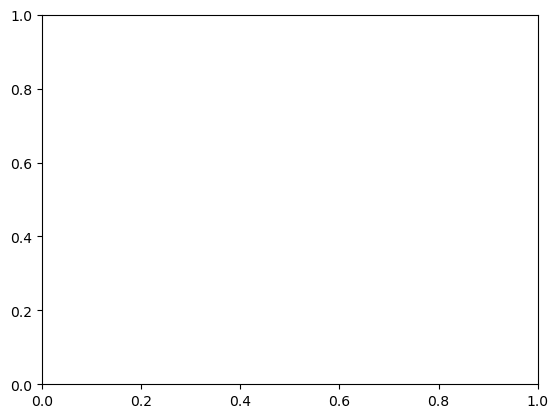

In [18]:
average_spectrum = np.mean(derived_data, axis = (0, 1))

plot(bias_line, average_spectrum)

# Grid 

In [57]:
grid_map =(asarray(make_map(current_cube, params)))

In [58]:
all_maps_median_filtered = median_filtering_all_maps(grid_map, 3, 1)

np.save('C:/Users/eugen/Documents/CODE/STM/Grids/All_maps_median_filtered_{}.npy'.format(file), all_maps_median_filtered)
all_maps_median_filtered = np.load('All_maps_median_filtered_{}.npy'.format(file))

OSError: [Errno 22] Invalid argument: "C:/Users/eugen/Documents/CODE/STM/Grids/All_maps_median_filtered_<_io.TextIOWrapper name='C:/Users/eugen/Documents/CODE/STM/Grids/Data/grid-spectroscopy004_median-filtered.npy' mode='r' encoding='cp1252'>.npy"

# Derivative average spectrum 

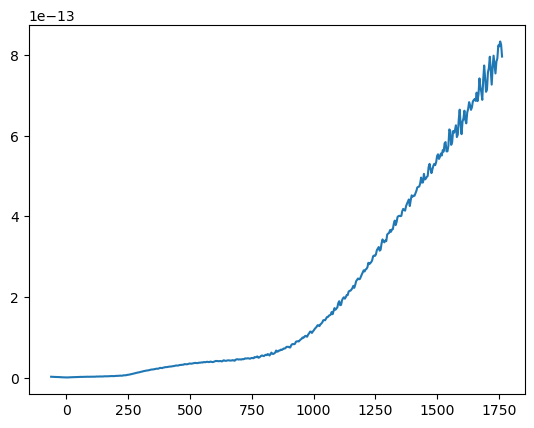

In [15]:
plot(bias_axis[10:-10], derivative_1d(average_spectrum, params)[10:-10])

# Fourier transform

In [17]:
def fourier(data):
    f=np.fft.fft2(data)
    fshift = np.fft.fftshift(f)         
    return fshift

    
def image_fourier (data, sizemap, m_tresh):
    fourier_ =  median_filtering(log(absolute(fourier(data))), 3, m_tresh)
    fig = figure()
    imshow(fourier_)


def map_in_energy_fourier(data, n, bias, size, _range, x_points, y_points, m_tresh):
    fig=figure(figsize = (size, size))
    data_1 = data[index_of_bias(bias, params)]
    e_plus = index_of_bias(bias + _range, params)
    e_minus = index_of_bias(bias - _range, params)
    average = average_data(data, e_minus, e_plus)
    median = median_filtering (average, n, m_tresh)
    
    derived_fourier = log(absolute(fourier(data_1)))
    derived_averaged_fourier = log(absolute(fourier(average)))
    derived_averaged_fourier_median = log(absolute(fourier(median)))
    
    subplot(1,2,1)
    imshow(data_1)
    xlabel('X', fontsize=16)
    ylabel('Y', fontsize=16)
    title('derived map', fontsize=16) 
    
    subplot(1,2,2)
    imshow(derived_fourier)
    xlabel('X', fontsize=16)
    ylabel('Y', fontsize=16)
    title('derived map fourier', fontsize=16) 
    
    
    global bias_glob
    nergy_glob = bias
    global fig_glob 
    fg_glob = fig       


interact(map_in_energy_fourier, data = fixed(grid_map), n = fixed(3),
         bias = FloatSlider(min = bias_end, max = bias_start, step =0.1, continuous_update = False), 
         size= IntSlider (min=20, max=30, step = 1, continuous_update=False), 
         x_points= IntSlider(min=0, max=300, step = 1, continuous_update=False), 
         y_points=IntSlider(min=0, max=300, step = 1, continuous_update=False), 
         _range = IntSlider(min=1, max=50, step = 1, continuous_update=False) , 
         m_tresh = FloatSlider(min=0.1, max=1, step = 0.1, continuous_update=False),
         params = fixed(params))

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='bias', max=1799.99995231628…

<function __main__.map_in_energy_fourier(data, n, bias, size, _range, x_points, y_points, m_tresh)>

# Median filtering (home made)

In [45]:
# Define your median filter function
def median_filter(dataset, window_size):
    if window_size <= 1:
        return dataset

    # Ensure window size is odd
    if window_size % 2 == 0:
        window_size += 1

    # Calculate the window radius (half of the size)
    radius = window_size // 2
    
    # Extend the dataset with padding to avoid edge problems
    dataset_padded = np.pad(dataset, pad_width=radius, mode='constant')
    
    # Function to calculate the median of a window
    calculate_median = lambda window: np.median(window)
    
    # Apply median filter to each row of the dataset
    dataset_filtered_padded = np.array([calculate_median([dataset_padded[i:i+window_size, j:j+window_size]])
                                        for i in range(dataset.shape[0]) for j in range(dataset.shape[1])]).reshape(dataset.shape)
    
    # Remove padding from the filtered dataset
    dataset_filtered = dataset_filtered_padded[:dataset.shape[0], :dataset.shape[1]]
    
    return dataset_filtered

# Define a function to update the filtered dataset and display the image
def median_filter_plot(selected_bias_value, window_size):
    # Clear the previous plot
    clear_output(wait=True)
    
    # Find the index of the closest value in the array
    closest_value_index = np.abs(bias_line - selected_bias_value).argmin()
    # Select the slice along the third dimension based on the index
    selected_slice = current_cube[:,:,closest_value_index]
    # Apply median filter to the selected slice
    filtered_slice = median_filter(selected_slice, window_size)


    # Plot the filtered image with a bigger size
    plt.figure(figsize=(10, 8))  # Adjust the figure size here
    
    # Plot the image with specified vmin and vmax
    plt.imshow(filtered_slice, cmap='viridis')
    plt.title("Bias = {} V".format(selected_bias_value))
    plt.axis('off')
    plt.colorbar()  # Add colorbar to show the color scale
    
    plt.show()

# Create a slider widget for selecting the slice value
bias_slider = widgets.SelectionSlider(options=[("%g"%i, i) for i in bias_line], description='Bias')

# Create a slider widget for selecting the window size
window_size_slider = widgets.IntSlider(value=1, min=1, max=9, step=2, description='Window Size')

# Define interactive output with a button to manually trigger the update
interact_manual(median_filter_plot, selected_bias_value=bias_slider, window_size=window_size_slider)

interactive(children=(SelectionSlider(description='Bias', options=(1.8, 1.7961923, 1.7923847, 1.7885771, 1.784…

<function __main__.update_filter_and_plot(selected_bias_value, window_size)>

# All maps

In [18]:
def map_in_energy_derive_fourier (data, bias, figure_size, m_tresh, params):  
    e = index_of_bias (bias, params)
    fig = figure(figsize = (figure_size, figure_size))
    median = median_filtering(data[e], 3, m_tresh)
    mean = average(data, (1,2))
    #mean = mean*(10**12)
    
    median_averaged = substract_average(median)
    standard = np.std(median_averaged)
    
    fourier_ = (median_filtering(log(absolute(fourier(median_averaged))), 3, m_tresh))
    fourier_1 = fourier_- np.min(fourier_)
    standard_fourier = np.std(fourier_1)
    
    fig = figure()
    fig.set_figheight(figure_size)
    fig.set_figwidth(figure_size*3)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    imshow(fourier_1 ,extent=[-2/params['len_x'],2/params['len_x'],-2/params['len_y'],2/params['len_y']])
    xlabel('X (1/nm)', fontsize=50,y=1)
    ylabel('Y (1/nm)', fontsize=50)
    #title(''.join('fourier transform of derived energy map at {} meV'.format(round(bias))), fontsize=50, y= 1.07)
    xticks(fontsize=50,rotation = 45)
    yticks(fontsize=50)

    global fig_glob 
    fig_glob = fig
    global bias_glob
    bias_glob = bias 
    global fourier_glob
    fourier_glob = fourier_ 


interact(map_in_energy_derive_fourier, data = fixed(grid_map), 
         bias = FloatSlider(min= bias_end, max=bias_start, step =0.1, continuous_update = False),
         figure_size= IntSlider (min=20, max=30, step = 1, continuous_update=False), 
         x= IntSlider(min=0, max=300, step = 1, continuous_update=False), 
         y=IntSlider(min=0, max=300, step = 1, continuous_update=False), 
         r = IntSlider(min=1, max=50, step = 1, continuous_update=False) , 
         m_tresh = FloatSlider(min=0.1, max=1, step = 0.1, continuous_update=False),
         params = fixed(params))


interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='bias', max=1799.99995231628…

<function __main__.map_in_energy_derive_fourier(data, bias, figure_size, m_tresh, params)>

# Gaussian filtering

In [ ]:
spec_filtered = make_spec(all_maps_filtered, params)

In [ ]:
interact(Gaussian_filtering_plot, data = fixed(current_cube), 
         x= FloatSlider(min=0, max = len_x, step = len_x/100, continuous_update=False), 
         y=FloatSlider(min=0, max=len_y, step = len_y/100, continuous_update=False), 
         sigma=IntSlider(min=1, max=15, step = 1, continuous_update=False), num_points = fixed(256), params = fixed(params))

In [ ]:
Filtered_data = all_gaussian(current_cube, sigma_global)
np.save('Gaussian_filtered_Data_{}.npy'.format(file), Filtered_data)
Filtered_data = np.load('Gaussian_filtered_Data_{}.npy'.format(file))
Filtered_map = make_map(Filtered_data, params)

# Shows the Gaussian filtered map and median filters it again

In [ ]:
interact(median_filtering_map, data = fixed(Filtered_map), size= IntSlider (min=15, max=20, step = 1, continuous_update=False),
         bias = FloatSlider(min = min(bias_start, bias_end), max = max(bias_start,bias_end),
         step =0.1, continuous_update = False), n = fixed(3),
         m_tresh = FloatSlider(min=0.01, max=2,step =0.01, continuous_update=False), params = fixed(params))

# First derivative

In [ ]:
derived_data = all_derive(Filtered_data, params)

In [ ]:
np.save('All_derive_{}.npy'.format(file), derived_data)

In [ ]:
derived_data = np.load('All_derive_{}.npy'.format(file))

In [ ]:
derived_map = make_map(derived_data, params)
plot(bias_axis[40:-40], np.mean(derived_map, (1,2))[40:-40])

In [ ]:
interact(map_in_energy_derived_with_average_spectra, data = fixed(derived_map), 
         bias = FloatSlider(min= min(bias_start,bias_end), 
         max=max(bias_start,bias_end)), figure_size = IntSlider (min=20, max=30, step = 1, continuous_update=False), 
         x = x_widget, y = y_widget,
         r = IntSlider(min=1, max=50, step = 1, continuous_update=False),
         m_tresh = FloatSlider(min=0.1, max=1, step = 0.1, continuous_update=False),
         lower_cut = lower_cut_widget, upper_cut = upper_cut_widget, 
         bar_lower_percentage= FloatSlider(min=0, max=20, step = 0.1, continuous_update=False), 
         bar_higher_percentage= FloatSlider(min=0, max=20, step = 0.1, continuous_update=False), params = fixed(params))

# Second derivative

In [ ]:
second_derivativeData = all_derive(derived_data, params)
second_derivativeMap = make_map(second_derivativeData, params)
plot(bias_axis[40:-40], np.mean(second_derivativeMap, (1,2))[40:-40])

In [ ]:
interact(map_in_energy_derived_with_average_spectra, data = fixed(second_derivativeMap), 
         bias = FloatSlider(min = min(bias_start,bias_end), 
         max=max(bias_start,bias_end)), figure_size = IntSlider (min=20, max=30, step = 1, continuous_update=False), 
         x = x_widget, y = y_widget,
         r = IntSlider(min=1, max=50, step = 1, continuous_update=False),
         m_tresh = FloatSlider(min=0.1, max=1, step = 0.1, continuous_update=False),
         lower_cut = lower_cut_widget, upper_cut = upper_cut_widget, 
         bar_lower_percentage= FloatSlider(min=0, max=20, step = 0.1, continuous_update=False), 
         bar_higher_percentage= FloatSlider(min=0, max=20, step = 0.1, continuous_update=False), params = fixed(params))

In [ ]:
interact(map_in_energy_derived, data = fixed(derived_map), bias = FloatSlider(min = min(bias_start, bias_end), 
         max = max(bias_start, bias_end), step =0.05, continuous_update = False), 
         figure_size= IntSlider (min=20, max=30, step = 1, continuous_update=False), 
         x= IntSlider(min=0, max=300, step = 1, continuous_update=False), 
         y=IntSlider(min=0, max=300, step = 1, continuous_update=False), 
         r = IntSlider(min=1, max=50, step = 1, continuous_update=False) , 
         m_tresh = FloatSlider(min=0.1, max=1, step = 0.1, continuous_update=False), 
         bar_lower_percentage= FloatSlider(min=0, max=20, step = 0.1, continuous_update=False), 
         bar_higher_percentage= FloatSlider(min=0, max=20, step = 0.1, continuous_update=False), 
         params = fixed(params))


# Spectroscopic map after filtering and derivating

In [ ]:
interact (map_in_energy_spectra_mean, data = fixed(derived_map), bias = bias_widget, 
          figure_size= IntSlider (min=20, max=30, step = 1, continuous_update=False), 
          x= x_widget, y=y_widget, r = FloatSlider(min=len_x/x_points+0.1, max=min(len_x,len_y), 
          step = len_x/100, continuous_update=False) , 
          m_tresh = FloatSlider(min=0.1, max=1, step = 0.1, continuous_update=False), 
          sigma = IntSlider(min=1, max=30, step = 1, continuous_update=False), 
          lower_cut=lower_cut_widget, upper_cut=upper_cut_widget, 
          bar_lower_percentage= FloatSlider(min=0, max=20, step = 0.1, continuous_update=False), 
          bar_higher_percentage= FloatSlider(min=0, max=20, step = 0.1, continuous_update=False),params = fixed(params))


In [ ]:
def map_in_energy_spectra_line_profile (data, energy, figure_size, x, y, r, m_tresh,sigma,lower_cut,upper_cut,bar_lower_percentage,bar_higher_percentage,width, params):
    bias_axis = linspace(params['bias_start'],params['bias_end'],params['spectrum_length'])                             
    x_1 = x_i(x,params)
    y_1 = y_i(y,params)
    r_1 = x_i(r,params)
    y_1_min = y_i(y - width/2 ,params)
    y_1_max = y_i(y + width/2 ,params)
    mean = mean_spectrum_circ(data,x_1,y_1,r_1, params['x_points'],params['y_points'],)
    filtered_mean = gaussian_filter1d(mean, sigma)
    e = index_of_bias(energy,params)
    theta = np.linspace(0, 2*np.pi, 100)
    radius = r
    a = radius*np.cos(theta)
    b = radius*np.sin(theta)
    median = median_filtering (data[e], 3, m_tresh)
    average_ = average(median[y_1_max:y_1_min],axis=0)
    fig = figure()
    fig.subplots_adjust(hspace=0.4, wspace=0.4) 
    fig.set_figheight(figure_size)
    fig.set_figwidth(figure_size*3)
    upper_index = index_of_bias(upper_cut,params)
    lower_index = index_of_bias(lower_cut,params)
  
    
    subplot(2,2,1)
    im = imshow(median, extent=[0,params['len_x'],0,params['len_y']])
    plot(a+x,b+y,color="red", linewidth=5)
    axhline(y = y, color = 'w', linestyle = '-', linewidth=5) 
    xlabel('X (nm)', fontsize=50, y=1.01)
    ylabel('Y (nm)', fontsize=50, x = 1.01)
    title(''.join('derived energy map at {} meV'.format(energy)), fontsize=50, y= 1.1)
    xticks(fontsize=50)
    yticks(fontsize=50)
    cbar =colorbar(im, boundaries=linspace(np.min(median)*bar_lower_percentage/100,np.max(median)*(100-bar_higher_percentage)/100,1000),shrink=1,ticks=linspace(np.min(median)*bar_lower_percentage/100,np.max(median)*(100-bar_higher_percentage)/100,10))
    cbar.minorticks_on()
    cbar.ax.tick_params(labelsize=50)
    
    subplot(2,2,2)
    plot(bias_axis[min(lower_index,upper_index):max(lower_index,upper_index)],filtered_mean[min(lower_index,upper_index):max(lower_index,upper_index)], linewidth=6)
    plot(bias_axis[e], filtered_mean[e], 'ro', markersize=25)
    xlabel('E (meV)', fontsize=50)
    ylabel('dI/dV (pS)', fontsize=50)
    title(''.join('Average Spectra of the map at the circle'.format(energy)), fontsize=50, y= 1.07)
    xticks(fontsize=50)
    yticks(fontsize=50)
    
    subplot(2,2,3)
    plot(arange(params['x_points']), average_)

    xlabel('X (nm)', fontsize=50)
    ylabel('dI/dV (pS)', fontsize=50)
    title(''.join('Average Spectra of the map along the line'.format(energy)), fontsize=50, y= 1.07)
    xticks(fontsize=50)
    yticks(fontsize=50)    
    plt.show()

In [ ]:
def map_in_energy_spectra_mean_3circs (data, energy, figure_size, x_1, y_1, r_1,x_2,y_2,r_2,x_3,y_3,r_3, m_tresh,sigma,lower_cut,upper_cut,bar_lower_percentage,bar_higher_percentage,n_1,n_2,n_3,params):
    
    x_1_i = x_i(x_1,params)
    y_1_i = y_i(y_1,params)
    r_1_i = x_i(r_1,params)
    x_2_i = x_i(x_2,params)
    y_2_i = y_i(y_2,params)
    r_2_i = x_i(r_2,params)
    x_3_i = x_i(x_3,params)
    y_3_i = y_i(y_3,params)
    r_3_i = x_i(r_3,params)
    
    e = index_of_bias(energy,params)
    theta = np.linspace(0, 2*np.pi, 100)
    
    
    mean_1 = mean_spectrum_circ(data,x_1_i,y_1_i,r_1_i,params['x_points'], params['y_points'])
    filtered_mean_1 = gaussian_filter1d(mean_1,sigma)
    fig = figure(figsize = (figure_size,figure_size))
    radius_1 = r_1
    a_1 = radius_1*np.cos(theta)
    b_1= radius_1*np.sin(theta)
    
    mean_2 = mean_spectrum_circ(data,x_2_i,y_2_i,r_2_i,params['x_points'], params['y_points'])
    filtered_mean_2 = gaussian_filter1d(mean_2,sigma)
    radius_2 = r_2
    a_2 = radius_2*np.cos(theta)
    b_2 = radius_2*np.sin(theta)    
 
    mean_3 = mean_spectrum_circ(data,x_3_i,y_3_i,r_3_i,params['x_points'], params['y_points'])
    filtered_mean_3= gaussian_filter1d(mean_3,sigma)
    radius_3 = r_3
    a_3 = radius_3*np.cos(theta)
    b_3 = radius_3*np.sin(theta)

    median = median_filtering (data[e], 3, m_tresh)
    fig = figure(figsize = (60,20))
    fig.subplots_adjust(hspace=0.1, wspace=0.1) 
    upper_index = index_of_bias(upper_cut,params)
    lower_index = index_of_bias(lower_cut,params)
  
    
    subplot(1,2,1)
    im = imshow(median, extent=(0,params['len_x'],0,params['len_y']))
    plot(a_1+x_1,b_1+y_1,color="aqua", linewidth=8)
    plot(a_2+x_2,b_2+y_2,color="red", linewidth=8)
    plot(a_3+x_3,b_3+y_3,color="lightgreen", linewidth=8)
    xlabel('X (nm)', fontsize=50, y = 1.01)
    ylabel('Y (nm)', fontsize=50, x = 1.01)
    title(''.join('dI/dV map at {} meV'.format("{:.2f}".format(energy))), fontsize=50, y= 1.1)
    xticks(fontsize=50)
    yticks(fontsize=50)
    cbar =colorbar(im, boundaries=linspace(np.min(median)*bar_lower_percentage/100,np.max(median)*(100-bar_higher_percentage)/100,1000),shrink=0.3,ticks=linspace(np.min(median)*bar_lower_percentage/100,np.max(median)*(100-bar_higher_percentage)/100,5).astype(int))
    cbar.minorticks_on()
    cbar.ax.tick_params(labelsize=50)
  
        
    subplot(1,2,2)
    plot(bias_axis[min(lower_index,upper_index):max(lower_index,upper_index)],n_1*asarray(filtered_mean_1[min(lower_index,upper_index):max(lower_index,upper_index)]),color="aqua", linewidth=8)
    plot(bias_axis[min(lower_index,upper_index):max(lower_index,upper_index)],n_2*asarray(filtered_mean_2[min(lower_index,upper_index):max(lower_index,upper_index)]),color="red", linewidth=8)    
    plot(bias_axis[min(lower_index,upper_index):max(lower_index,upper_index)],n_3*asarray(filtered_mean_3[min(lower_index,upper_index):max(lower_index,upper_index)]),color="lightgreen", linewidth=8)    
    margins(x=0)
    xlabel('E (meV)', fontsize=50)
    ylabel('dI/dV (pS)', fontsize=50)
    title(''.join('Average Spectra of the map at the circle'.format(energy)), fontsize=50, y= 1.07)
    xticks(fontsize=50)
    yticks(fontsize=50)
    ylim(0)
    subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
    global fig_glob 
    fig_glob = fig
    global energy_glob
    energy_glob = energy


In [ ]:
interact(map_in_energy_spectra_mean_3circs, data = fixed(derived_map), bias = bias_widget, 
         figure_size= IntSlider (min=20, max=30, step = 1, continuous_update=False), 
         x_1= FloatSlider(min=0, max=len_x, step = len_x/100, continuous_update=False), 
         y_1=FloatSlider(min=0, max=len_y, step = len_y/100, continuous_update=False), 
         r_1 = FloatSlider(min=len_x/x_points+0.5, max=min(len_x,len_y), 
         step = len_x/100, continuous_update=False),
         x_2= FloatSlider(min=0, max=len_x, step = len_x/100, continuous_update=False),
         y_2=FloatSlider(min=0, max=len_y, step = len_y/100, continuous_update=False),
         r_2 = FloatSlider(min=len_x/x_points+0.5, max=min(len_x,len_y),
         step = len_x/100, continuous_update=False),
         x_3= FloatSlider(min=0, max=len_x, step = len_x/100, continuous_update=False), 
         y_3=FloatSlider(min=0, max=len_y, step = len_y/100, continuous_update=False), 
         r_3 = FloatSlider(min=len_x/x_points+0.5, max=min(len_x,len_y), 
         step = len_x/100, continuous_update=False), 
         m_tresh = FloatSlider(min=0.1, max=10, step = 0.1, continuous_update=False), 
         sigma=IntSlider(min=1, max=30, step = 1, continuous_update=False),
         lower_cut=lower_cut_widget,upper_cut=upper_cut_widget, 
         bar_lower_percentage= FloatSlider(min=0, max=20, step = 0.1, continuous_update=False), 
         bar_higher_percentage= FloatSlider(min=0, max=20, step = 0.1, continuous_update=False), 
         n_1= FloatSlider(min=0.8, max=1, step = 0.01, continuous_update=False), 
         n_2= FloatSlider(min=0.8, max=1, step = 0.01, continuous_update=False), 
         n_3= FloatSlider(min=0.8, max=1, step = 0.01, continuous_update=False),params = fixed(params))

#btn_5

In [ ]:
interact(map_in_energy_derived, data = fixed(derived_map), bias = FloatSlider(min= bias_start, max=bias_end, step =0.05, continuous_update = False), figure_size= IntSlider (min=20, max=30, step = 1, continuous_update=False), 
         x= IntSlider(min=0, max=300, step = 1, continuous_update=False), y=IntSlider(min=0, max=300, step = 1, continuous_update=False), r = IntSlider(min=1, max=50, step = 1, continuous_update=False) , m_tresh = FloatSlider(min=0.1, max=1, step = 0.1, continuous_update=False),bar_lower_percentage= FloatSlider(min=0, max=20, step = 0.1, continuous_update=False),bar_higher_percentage= FloatSlider(min=0, max=20, step = 0.1, continuous_update=False),params = fixed(params))

btn_4

In [ ]:
interact(map_in_energy_derived_with_average_spectra, data = fixed(derived_map), 
         bias = bias_widget, figure_size = IntSlider (min=20, max=30, step = 1, continuous_update = False), 
         x = x_widget, y = y_widget,
         r = IntSlider(min=1, max=50, step = 1, continuous_update=False),
         m_tresh = FloatSlider(min=0.1, max=1, step = 0.1, continuous_update=False),
         lower_cut = lower_cut_widget, upper_cut = upper_cut_widget, 
         bar_lower_percentage= FloatSlider(min=0, max=20, step = 0.1, continuous_update=False), 
         bar_higher_percentage= FloatSlider(min=0, max=20, step = 0.1, continuous_update=False), params = fixed(params))

In [ ]:
interact(map_in_energy_derive_fourier, data = fixed(derived_map), bias = FloatSlider(min= bias_start, max=bias_end, step =0.1, continuous_update = False), figure_size= IntSlider (min=20, max=30, step = 1, continuous_update=False),
         x= IntSlider(min=0, max=300, step = 1, continuous_update=False), y=IntSlider(min=0, max=300, step = 1, continuous_update=False), r = IntSlider(min=1, max=50, step = 1, continuous_update=False) , m_tresh = FloatSlider(min=0.1, max=1, step = 0.1, continuous_update=False),params = fixed(params))


In [ ]:
def normalizing_map (data):
    norm = []
    for i in range (len(data)):
        norm.append(data[i]/sum(data[i]))
    return norm


In [ ]:
normalized_map = asarray(normalizing_map (derived_map))

# Treating topographic data

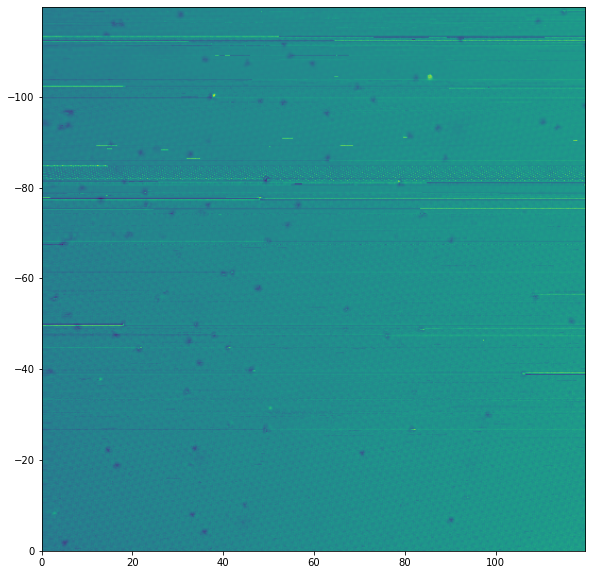

In [15]:
topography = topo[:,:,4]
topography = flip(topography,0)
slope_corrected_topography = substract_average(topography)
figure(figsize = (10,10))

params = {'len_x':len_x, 'len_y': len_y, 'x_points':x_points , 'y_points': y_points, 'bias_start':bias_start,
          'bias_end':bias_end, 'spectrum_length': spectrum_length, 'slope_corrected_topography' : slope_corrected_topography}

imshow(slope_corrected_topography, extent=[0, len_x, 0, len_y])

# Polynomyal slope

In [21]:
interact(substract_polynomyal_slope,
         data = fixed(slope_corrected_topography), 
         num_points_x = fixed(x_points), 
         num_points_y = fixed(y_points),
         order = IntSlider(min=1,max=10,step=1, continuous_update=False),
         size = IntSlider (min=5, max=15, step = 1, continuous_update=False),
         len_x = fixed(len_x), len_y = fixed(len_y),params = fixed(params))


interactive(children=(IntSlider(value=1, continuous_update=False, description='order', max=10, min=1), IntSlid…

<function __main__.substract_polynomyal_slope(data, order, size, len_x, len_y, params)>